# <font color='blue'> Simulación Monte Carlo del Precio de Acciones

Podemos partir definiendo que el Movimiento Browniano Geométrico sigue la ecuación diferencial estocastica:

$$dS = \mu S dt + \sigma S dW_t$$

donde:

$S$: Precio de la acción

$\mu$: coeficiente de deriva, esto es, el promedio de los rendimientos sobre un periodo o el rendimiento esperado instántaneo.

$\sigma$: coeficiente de difusión, esto es, la volatilidad.

$W_t$: Movimiento browniano
    

Esta ecuación admite una solución, dada por:

$$S(t)=S_0 e^{(\mu -\frac{1}{2}\sigma^2)t+\sigma W_t}$$

donde $S_0=S(0)$ es el precio inicial.

Para fines de la simulación, usamos la fórmula recursiva:
    
$$S(t_{i+1})=S(t_i)exp(\mu - \frac{1}{2}\sigma^2)(t_{i+1}- t_i) + \sigma \sqrt{t_{i+1}-t_i} Z_{i+1}$$

donde $Z_i$ es una variable aleatoria normal estándar e $i=1,2,3,...T$ es el índice de tiempo.

In [3]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternativa
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Usamos yfinance para descargar datos de yahoo finance

In [5]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Using legacy 'setup.py install' for multitasking, since package 'wheel' is not installed.
    Running setup.py install for multitasking: started
    Running setup.py install for multitasking: finished with status 'done'


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\program files\python39\python.exe -m pip install --upgrade pip' command.


In [6]:
import numpy as np
import pandas as pd
import yfinance as yf

Definimos los parametros de los datos. Usamos acciones de Microsoft.

In [7]:
RISKY_ASSET = 'MSFT'
START_DATE = '2022-01-01'
END_DATE = '2022-05-31'

Los cargamos en un data frame de pandas

In [8]:
df = yf.download(RISKY_ASSET, start=START_DATE, end=END_DATE, adjusted=True)
print(f'Descargados {df.shape[0]} renglones de datos.')

[*********************100%***********************]  1 of 1 completed
Descargados 102 renglones de datos.


In [9]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,335.350006,338.000000,329.779999,334.750000,333.283020,28865100
2022-01-04,334.829987,335.200012,326.119995,329.010010,327.568176,32674300
2022-01-05,325.859985,326.070007,315.980011,316.380005,314.993530,40054300
2022-01-06,313.149994,318.700012,311.489990,313.880005,312.504486,39646100
2022-01-07,314.149994,316.500000,310.089996,314.040009,312.663788,32720000


Calculamos los rendimientos diarios

Usamos los métodos: 

dropna(), que filtrar los valores de una estructura de datos pandas para dejar solo aquellos no nulos.

pct_change(), que calcula el porcentaje de cambio entre la entrada actual y la anterior

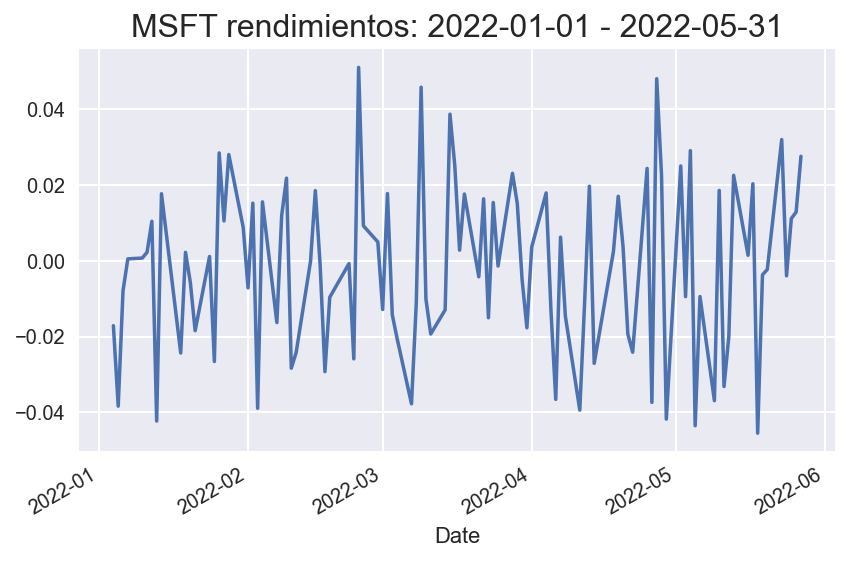

Rendimiento promedio: -0.17%


In [10]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()   

ax = returns.plot()
ax.set_title(f'{RISKY_ASSET} rendimientos: {START_DATE} - {END_DATE}', 
             fontsize=16)


plt.tight_layout()
#plt.savefig('imagen1.png')
plt.show()

print(f'Rendimiento promedio: {100 * returns.mean():.2f}%')

Graficamos el histograma para darnos una idea de si realmente siguen una distribución normal o no.

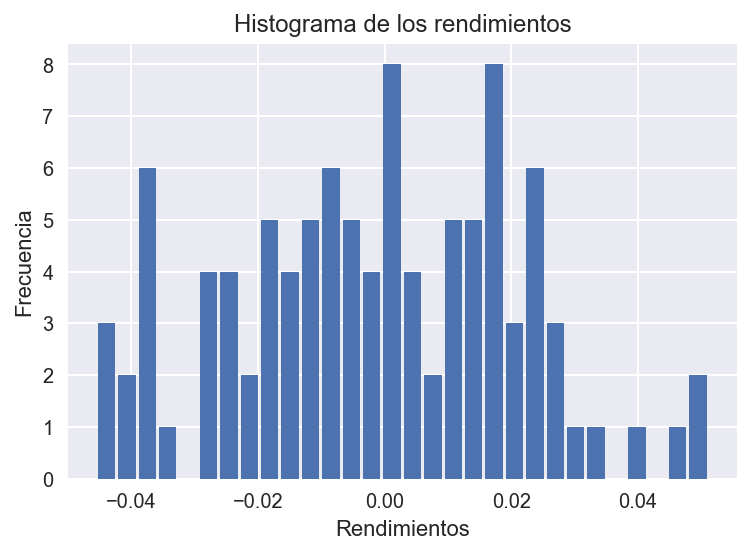

In [11]:
plt.hist(x=returns, rwidth=0.85, bins=30)
plt.title('Histograma de los rendimientos')
plt.xlabel('Rendimientos')
plt.ylabel('Frecuencia')

plt.show()

Ahora dividimos el conjunto de datos en dos: un conjunto de entrenamiento y uno de prueba.

In [12]:
train = returns['2021-01-01':'2022-04-30']
test = returns['2022-05-01':'2022-06-07']

Definimos los parámetros de la simulación

In [13]:
T = len(test)   # longitud del periodo de predicción
N = len(test)   # número de incrementos unitarios en el periodo de predicción
S_0 = adj_close[train.index[-1]]  # precio inicial
N_SIM = 100

# Obtenemos los parametros del subconjunto de entrenamiento

mu = train.mean()    
sigma = train.std()

Antes de continuar comparamos gráfica e histograma

In [14]:
mu, sigma

(-0.0020480132559483723, 0.02197466732248023)

In [15]:
from scipy import stats

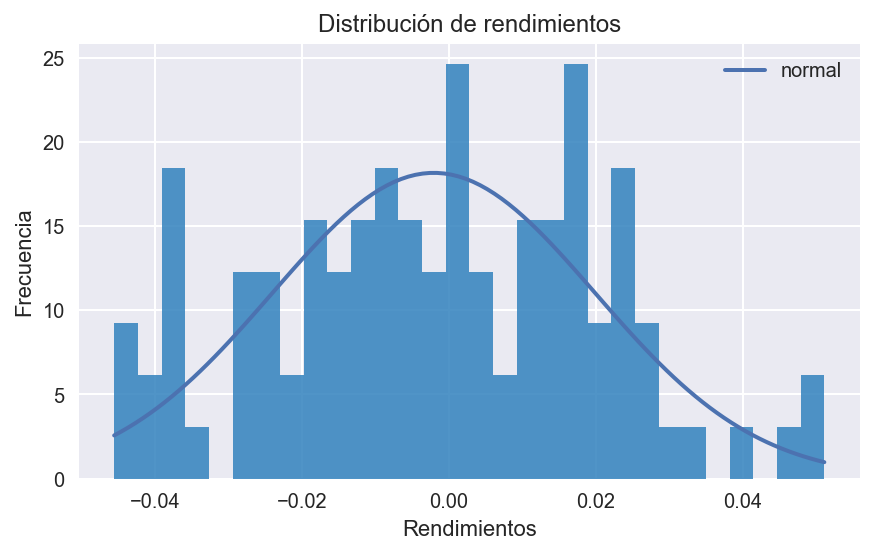

In [16]:
x_hat = np.linspace(min(returns), max(returns), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=returns, density=True, bins=30, color="#3182bd", alpha=0.85)
ax.set_title('Distribución de rendimientos')
ax.set_xlabel('Rendimientos')
ax.set_ylabel('Frecuencia')
ax.legend();

También podemos utilizar una gráfica cuantil-cuantil

In [17]:
import pylab 

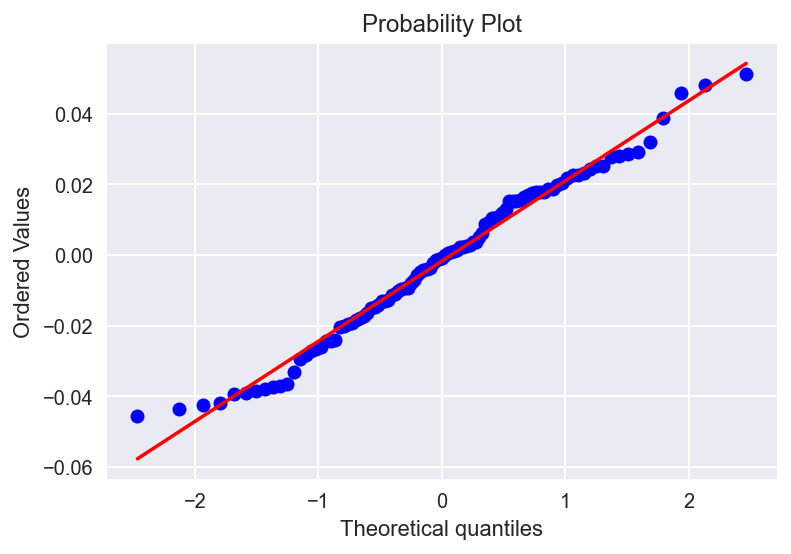

In [18]:
stats.probplot(returns, dist="norm", plot=pylab)
pylab.show()

In [19]:
from scipy.stats import kstest

In [20]:
kstest(returns, 'norm', args=(mu, sigma))

KstestResult(statistic=0.08023086080053665, pvalue=0.5082855049481381)

Definimos la función para la simulación

In [21]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=242):

    np.random.seed(random_seed)  # fijamos la semilla
    
    dt = T/N                     # incremento temporal
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)   # Matriz (n_sim, T+1)
    S_t = np.insert(S_t, 0, s_0, axis=1)                 #Los reglones son trayectorias , columnas son tiempo
    
    return S_t

Corremos la simulación

In [22]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

Y graficamos los resultados

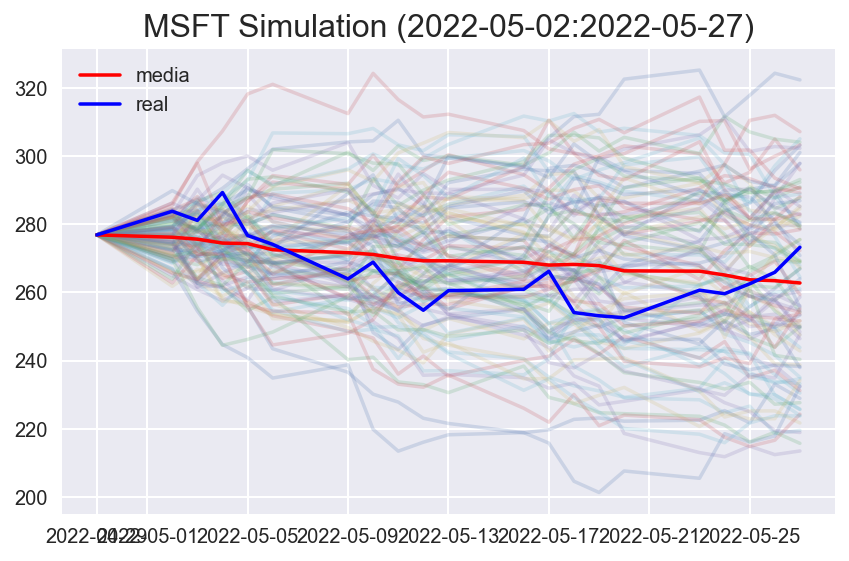

In [23]:
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)

# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()

#### Observaciones

* Recordar que, como para cualquier Monte Carlo, entre más muestras, mejor resultado se obtiene.
* El método MC usa un proceso de discretización para simular fenómenos continuos.
* Aquí se trabaja con vectores, lo cual evita bucles tipo for, que pueden ser ineficientes para este tipo de simulaciones.


Podemos revisar el tiempo de simulación:

In [24]:
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

154 µs ± 2.29 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


El módulo timeit cronometra fragmentos pequeños de código

#### Reducción de varianza

Podemos utilizar la técnica de variables antiteticas para reducir la varianza en el código anterior.

Para eso, hay que observar que las trayectorias fueron producidas generando variables aleatorias 
con distribución normal estándar $[ \epsilon_1, ..., \epsilon_t]$.

Así, dividiremos la muestra en dos y a una mitad le asignaremos las variables antitéticas $[ -\epsilon_1, ..., -\epsilon_t]$ y usarmemos el mismo estimador estadistico.

Reescribimos la función, agregando un argumento. 

In [25]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42, antithetic_var=False):

    np.random.seed(random_seed)
    
    # incremento de tiempo
    dt = T/N
    
    # Movimiento Browniano con variables antiteticas
    if antithetic_var:
        dW_ant = np.random.normal(scale = np.sqrt(dt), 
                                  size=(int(n_sims/2), N + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else: 
        dW = np.random.normal(scale = np.sqrt(dt), 
                              size=(n_sims, N + 1))
  
    # evolucion del proceso
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW, 
                                 axis=1)) 
    S_t[:, 0] = s_0
    
    return S_t

Ahora comparamos los tiempos

In [26]:
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)  # sin variables antiteticas

88.1 µs ± 6.38 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [27]:
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N, antithetic_var=True) # con variables antiteticas

70 µs ± 1.06 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Opciones Europeas

Una opción europea es aquella opción financiera donde el comprador de la misma podrá ejercerla solo cuando llegue el vencimiento del contrato.

Para este caso existen fórmulas analiticas para el precio de las opciones. Nosotros usaremos estas fórmulas para la simulación (revisar):

Call:

$$C(S_t,t)=N(d_1)S_t-N(d_2)Ke^{-r(T-t)}$$

Put:

$$P(S_t,t)=-N(-d_2)Ke^{-r(T-t)} - N(-d_1)S_t$$

donde

$$d_1=\frac{1}{\sigma \sqrt{T-t}}[ln(\frac{S_t}{K})+(r+\frac{\sigma^2}{2})(T-t)]$$


$$d_2=d_1-\sigma \sqrt{T-t}$$

Notación:

* S_0: precio inicial de la acción
* K: precio Strike
* r: tasa libre de riesgo anual
* $\sigma$: volatilidad
* T: Tiempo
* N: número de incrementos de las simulaciones

El precio de la opción es

Call:
    
$$max(S_T-K, 0)$$

Put:

$$max(K-S_T, 0)$$

In [28]:
import numpy as np
from scipy.stats import norm

In [29]:
S_0 = 100
K = 100
r = 0.05
sigma = 0.50
T = 1 # 1 año
N = 252 # 252 días en un año
dt = T / N # paso de tiempo
N_SIMS = 1000000 # numero de simulaciones 
discount_factor = np.exp(-r * T)

In [30]:
def black_scholes_analytical(S_0, K, T, r, sigma, type='call'):
    
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S_0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if type == 'call':
        val = (S_0 * norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * norm.cdf(d2, 0, 1))
    elif type == 'put':
        val = (K * np.exp(-r * T) * norm.cdf(-d2, 0, 1) - S_0 * norm.cdf(-d1, 0, 1))
    else:
        raise ValueError('Wrong input for type!')
        
    return val

In [31]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='call')

21.79260421286685

Simulamos por MC el precio:

In [32]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, n_sims=N_SIMS, T=T, N=N)

Se usa el factor de descuento para calcular el valor presente del payoff

In [33]:
premium = discount_factor * np.mean(np.maximum(0, gbm_sims[:, -1] - K))

In [34]:
premium

21.756178586245806

Comentar: revisar librería Quantlib